# 영화평 Text 분류 - Sentiment Analysis

IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset

- IMDb site 의 50,000 개 영화평 text 로 구성   

  
- 25,000 training set 과 25,000 testing set 으로 구성 (training set 과 test set 이 반반임)

  
- postive / negative reivew 가 동일한 숫자로 구성


- kreas.imbd 사용. 이미 preprocessing 이 되어 있고 review 내의 각 단어는 integer 숫자로 변환되어 있음.  
  (빈번히 사용되는 순서로 숫자 부여) 
  

- num_words=10000 - training set 에 가장 빈번히 등장하는 상위 10,000 개 단어 유지

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

In [23]:
imdb = keras.datasets.imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

## Data 탐색

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [25]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [26]:
print(X_train[0][:50])
print()
print(y_train[0: 10])
print()

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447]

[1 0 0 1 0 0 1 0 1 0]



### 영화 감상평 min, max 길이 check

In [27]:
max = 0
idx = 0
for i, arr in enumerate(X_train):
    if max < len(arr):
        max = len(arr)
        idx = i
print("최대길이 : ", max, "   index = ", idx)

min = 99999
idx = 0
for i, arr in enumerate(X_train):
    if min > len(arr):
        min = len(arr)
        idx = i
print("최소길이 : ", min, "    index = ", idx)

최대길이 :  2494    index =  17934
최소길이 :  11     index =  6719


## word-to-index 및 index_to_word Look-up table 작성

word dictionary : imdb.get_word_index()

In [28]:
word2index = imdb.get_word_index()

In [29]:
len(word2index)

88584

In [30]:
#sorted(word2index.items(), key=lambda kv: kv[1])

In [31]:
sorted(word2index.items(), key=lambda kv: kv[1])[:5]

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5)]

## 관례적으로 처음 4 개의 index (0, 1, 2, 3) 은 reserve 되어 있으므로 이를 word2index 에 반영

In [32]:
# reserved indexes
word2index = {k:(v+3) for k, v in word2index.items()}

word2index["<PAD>"] = 0
word2index["<START>"] = 1
word2index["<UNK>"] = 2
word2index["<UNUSED>"] = 3

index2word = dict([(value, key) for (key, value) in word2index.items()])

In [33]:
sorted(word2index.items(), key=lambda kv: kv[1])[:10]

[('<PAD>', 0),
 ('<START>', 1),
 ('<UNK>', 2),
 ('<UNUSED>', 3),
 ('the', 4),
 ('and', 5),
 ('a', 6),
 ('of', 7),
 ('to', 8),
 ('is', 9)]

In [34]:
' '.join([index2word.get(i, '?') for i in X_train[0]])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Data Preparation

입력 data 의 길이와 dimension 을 neural network 의 tensor 형태로 convert.

keras 의 pad_sequences 함수 사용. maximum length = 256 으로 통일

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
X_train = pad_sequences(X_train, value=word2index["<PAD>"], padding='post', maxlen=256)

X_test = pad_sequences(X_test, value=word2index["<PAD>"], padding='post', maxlen=256)

In [37]:
X_train.shape

(25000, 256)

In [38]:
print(X_train[205])

[   1    4  425  144   28   77    4 4055   15   16   64   29  122 1135
   10   10   50   16  164   23    4   20   15   16   52    4 2786    7
    4   20  152   66    2   19    4  114   10   10    4   64  155   15
   13   70   79   39    4   20    9   15   29   16    6   52  492   21
    6  364  113  394  415   10   10  146  806   15   13    2   61  278
    5   58   23   14   20   13  219   84 1200    4  750   11    4  655
    7    4   20   13 2674 1383   15   12   80  128   51    6 1323   13
  188  433   10   10   48   50    9    6 5943   15   13   70   97    8
   29 1325    9    8  796 1504   27  113    8  160 1845   88  231  102
    9  407   57   27 3647    7 3384    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

## 모델 구성

1) 첫 번째 층 - word Embedding 층

    keras.layers.Embedding(input_dim, output_dim)
    
    input_dim - size of vocaburary
    output_dim - dimension of dense embedding
    
    output shape = (batch_size, output_dim, input_dim)
    
2) LSTM 층  

3) 마지막 층-  sigmoid 활성화 함수를 사용하여 0과 1 사이의 실수를 출력합니다. 이 값은 확률 또는 신뢰도를 나타냅니다.

In [39]:
vocab_size = 10000
model = Sequential()
model.add(Embedding(vocab_size, 64))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 652,449
Trainable params: 652,449
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer=tf.train.AdamOptimizer(), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_split=0.2, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 20s 990us/sample - loss: 0.6921 - acc: 0.5186 - val_loss: 0.6900 - val_acc: 0.5238
Epoch 2/10
20000/20000 [==============================] - 19s 938us/sample - loss: 0.6716 - acc: 0.5725 - val_loss: 0.6038 - val_acc: 0.6126
Epoch 3/10
20000/20000 [==============================] - 19s 939us/sample - loss: 0.6114 - acc: 0.7085 - val_loss: 0.5305 - val_acc: 0.7736
Epoch 4/10
20000/20000 [==============================] - 19s 925us/sample - loss: 0.5585 - acc: 0.7483 - val_loss: 0.4742 - val_acc: 0.8232
Epoch 5/10
20000/20000 [==============================] - 19s 935us/sample - loss: 0.5104 - acc: 0.7870 - val_loss: 0.5098 - val_acc: 0.7896
Epoch 6/10
20000/20000 [==============================] - 19s 956us/sample - loss: 0.4722 - acc: 0.8146 - val_loss: 0.4507 - val_acc: 0.8240
Epoch 7/10
20000/20000 [==============================] - 19s 949us/sample - loss: 0.4600 - acc: 0.8175 -

In [42]:
results = model.evaluate(X_test, y_test)
print(results)

25000/25000 [==============================] - 84s 3ms/sample - loss: 0.5539 - acc: 0.7768
[0.5538689239501953, 0.77676]


In [43]:
hist = history.history

In [44]:
hist.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [45]:
len(hist['loss'])

10

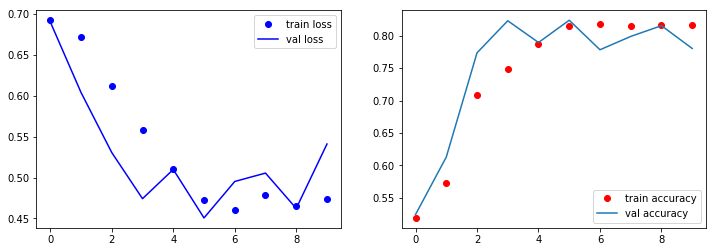

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
ax1.plot(np.arange(epochs), hist['loss'], 'bo', label='train loss')
ax1.plot(np.arange(epochs), hist['val_loss'], 'b', label='val loss')
ax1.legend()

ax2 = plt.subplot(122)
ax2.plot(np.arange(epochs), hist['acc'], 'ro', label='train accuracy')
ax2.plot(np.arange(epochs), hist['val_acc'], label='val accuracy')
ax2.legend(loc=4)
plt.show()

In [48]:
y_prediction = model.predict(X_test)

In [49]:
y_pred = y_prediction > 0.5

In [50]:
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.7418952041807335
Confusion matrix:


array([[11398,  4479],
       [ 1102,  8021]], dtype=int64)